# Hate Speech Classification

1. 260212846 - Vincent Tanjaya
2. 2602061580 - Dave Andrew Nathaniel
3. 2602073044 - Jessica Ryan

In [1]:
# Import necessary library
import string
import random
import joblib
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, gutenberg, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tag import pos_tag

In [2]:
# Download NLTK packages
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset from google drive
data = pd.read_csv('drive/MyDrive/NLP/HateSpeechDatasetBalanced.csv')

eng_stopwords = set(stopwords.words('english')) # Get english stopwords ("i", "me", ...)
porter = PorterStemmer() # Initialize Stemmer
wnl= WordNetLemmatizer() # Initialize WNL
data.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1.0
1,just by being able to tweet this insufferable ...,1.0
2,that is retarded you too cute to be single tha...,1.0
3,thought of a real badass mongol style declarat...,1.0
4,afro american basho,1.0


In [5]:
import re

def compress_repeating_char(word):
    # with Regular Expression, commpress repeating char
    # ex. LOOOOOOL -> LOL
    # ex. NICEEEEEE -> NICE
    return re.sub(r'(.)\1{2,}', r'\1', word)

list_words = []
for content in data['Content']:
    if content:
        content = str(content) # Convert to type string
        ws = word_tokenize(content) # Tokenize the sentences to words e.g "I love macaroni" -> "I", "love", "macaroni"
        ws = [compress_repeating_char(w) for w in ws] # Apply compress repeating char to all of the words
        list_words.extend(ws) # Add the new list of words to the list

list_words = [word.lower() for word in list_words if word not in eng_stopwords] # Remove stop words
list_words = [word.lower() for word in list_words if word not in string.punctuation] # Remove punctuations
list_words = [word.lower() for word in list_words if word.isalpha()] # Remove non alphabet words
list_words = [word.lower() for word in list_words if word not in 'br'] # Remove br because some of the dataset have random br
list_words = [porter.stem(word) for word in list_words] # Apply stemmer to the list of words
list_words = [wnl.lemmatize(word) for word in list_words] # Apply lemmatization to the list of words
list_words = [w for w in list_words if w != "nan"] # Remove nan from the list of words
print(list_words[:5])

['denial', 'normal', 'con', 'ask', 'comment']


In [6]:
fd = FreqDist(list_words) # Get the Frequent Distribution of the words

# Because the dataset used is massive, the list of words that will be recorded is only the 2000 most common word
# This comes with a cost because some hateful words might appear less than the 2000 threshold cannot be recorded
# But by experimentation, 2000 threshold is good enough for the model
list_words = []
for word, freq in fd.most_common(2000):
    list_words.append(word)

    # Print to see the example of it
    if freq > 50000:
      print(word, freq)

articl 111841
slut 93031
page 87280
like 80726
would 69253
one 64293
peopl 61449
edit 60842
use 59521
wikipedia 58392
whatev 56070
get 54545
talk 53740
plea 52030
think 51406
fuck 50171


In [7]:
# Convert the data from csv to labeled reviews
# The labeled reviews will have the format of
# [
    # (sent, 'hateful'),
    # (sent, 'non-hateful'),
    # .....
# ]

labeled_review = []
for sent, label in zip(data['Content'], data['Label']):
    if label == 0 :
        labeled_review.append((str(sent), 'non-hateful'))
    else:
        labeled_review.append((str(sent), 'hateful'))

print(labeled_review[:5])

[('denial of normal the con be asked to comment on tragedies an emotional retard', 'hateful'), ('just by being able to tweet this insufferable bullshit proves trump a nazi you vagina', 'hateful'), ('that is retarded you too cute to be single that is life', 'hateful'), ('thought of a real badass mongol style declaration of war the attackers capture a citizen of the soon to be', 'hateful'), ('afro american basho', 'hateful')]


In [8]:
# Get the dataset from the labeled reviews
# The dataset will be occurence of the 2000 most common words in the specific sentence
# For example:
# [
    # ({
        # 'articl': False
        # 'slut': True
        # 'bitch': True
        # 'whatev': True
        #  ...
    # }, "hateful"),
    # ({
        # 'articl': True,
        # 'slut': False,
        # 'bitch': False,
        # 'whatev': True,
        #  ...
    # }, "non-hateful"),
# ]
# From this dataset the model can learn the pattern for hateful and non hatefule sentences
dataset = []
for sentence, sentiment in labeled_review[:5000]:
    dict = {}
    # Use the same preprocessing for the dataset
    words = [word.lower() for word in word_tokenize(sentence)] # Word Tokenize
    words = [compress_repeating_char(w) for w in words] # Compress Repeating Char
    words = [word.lower() for word in words if word not in eng_stopwords] # Remove stopwords
    words = [word.lower() for word in words if word not in string.punctuation] # Remove punctuations
    words = [word.lower() for word in words if word.isalpha()] # Remove non alphabet text
    words = [word.lower() for word in words if word not in 'br'] # Remove br

    # Create the dataset structure
    for feature in list_words:
        dict[feature] = feature in words
    dataset.append((dict, sentiment))

print(dataset[:5])

[({'articl': False, 'slut': False, 'page': False, 'like': False, 'would': False, 'one': False, 'peopl': False, 'edit': False, 'use': False, 'wikipedia': False, 'whatev': False, 'get': False, 'talk': False, 'plea': False, 'think': False, 'fuck': False, 'see': False, 'go': False, 'know': False, 'make': False, 'delet': False, 'thank': False, 'say': False, 'time': False, 'want': False, 'also': False, 'need': False, 'sourc': False, 'look': False, 'good': False, 'even': False, 'woman': False, 'u': False, 'work': False, 'mean': False, 'person': False, 'realli': False, 'bitch': False, 'name': False, 'well': False, 'right': False, 'could': False, 'take': False, 'help': False, 'inform': False, 'call': False, 'remov': False, 'love': False, 'tri': False, 'link': False, 'thing': False, 'face': False, 'new': False, 'block': False, 'point': False, 'discus': False, 'user': False, 'comment': True, 'black': False, 'back': False, 'much': False, 'list': False, 'chang': False, 'mani': False, 'imag': False,

In [9]:
# Initialize Accuracy array that will hold the accuracy of all the models
accuracy_array = []
accuracy_label = ['Naive Bayes', 'Linear SVC', 'ADA Boost', 'Decision Tree']

In [11]:
# Import necessary library
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test, classifier, plot_title):
    # Extracting features and labels from the test set
    test_features = [fs for (fs, label) in test]
    test_labels = [label for (fs, label) in test]

    # Getting predictions from the classifier
    predictions = classifier.classify_many(test_features)

    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, predictions, labels=classifier.labels())

    # Plotting the heatmap of the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.labels(), yticklabels=classifier.labels())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(plot_title)
    plt.show()

    return test_features, test_labels, predictions

def print_classification_report(test_lables, predictions, labels):
    # Print classification report
    print(classification_report(test_labels, predictions, target_names=labels))

# Naive Bayes

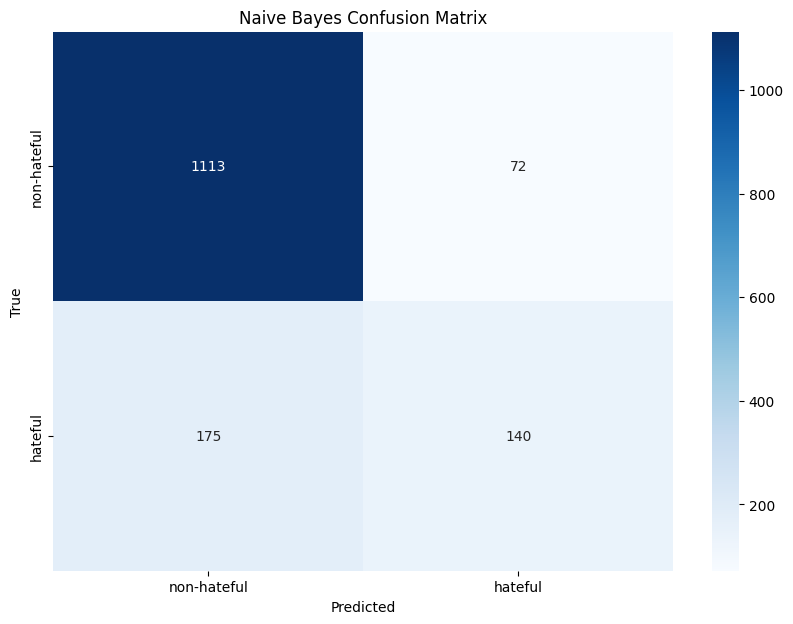

              precision    recall  f1-score   support

 non-hateful       0.66      0.44      0.53       315
     hateful       0.86      0.94      0.90      1185

    accuracy                           0.84      1500
   macro avg       0.76      0.69      0.72      1500
weighted avg       0.82      0.84      0.82      1500

Accuracy: 0.8353333333333334, Iteration: 1


In [12]:
# Import necessary library
import pickle
from nltk.classify import NaiveBayesClassifier, accuracy # Import the naive bayes classifier from the NLTK library

# Initialize iter and acc with 0
iter = 0
acc = 0

# Iterate until the accuracy exceeded 0.85 (max 10 iteration)
# For each iteration, the dataset will be shuffled
while acc < 0.80 and iter < 10:
    random.shuffle(dataset) # Shuffle the dataset

    # Train Test Split
    counter = int(len(dataset) * 0.7)
    train = dataset[:counter]
    test = dataset[counter:]

    classifier = NaiveBayesClassifier.train(train) # Train the naive bayes classifier
    acc = accuracy(classifier, test) # Calculate the accuracy of the model
    iter += 1

# Plot the accuracy matrix and classification report
test_features, test_labels, predictions = plot_confusion_matrix(test, classifier, 'Naive Bayes Confusion Matrix')
print_classification_report(test_labels, predictions, classifier.labels())

# Print the accuracy and append it to an array
accuracy_array.append(acc)
print(f"Accuracy: {acc}, Iteration: {iter}")

# Save the model to a joblib format
file = open('drive/MyDrive/NLP/naive.joblib', 'wb')
classifier = joblib.dump(classifier, file)
file.close()

# Linear SVC

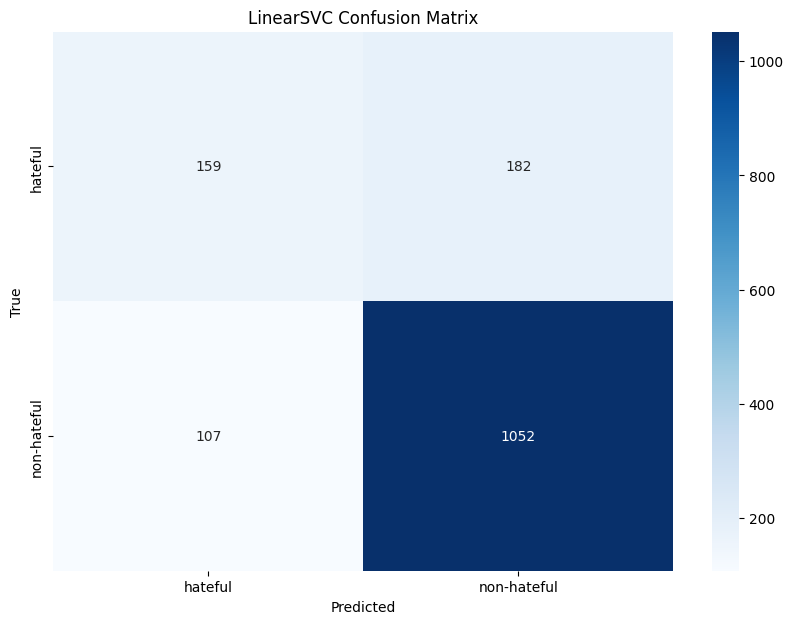

              precision    recall  f1-score   support

     hateful       0.60      0.47      0.52       341
 non-hateful       0.85      0.91      0.88      1159

    accuracy                           0.81      1500
   macro avg       0.73      0.69      0.70      1500
weighted avg       0.79      0.81      0.80      1500

Accuracy: 0.8073333333333333, Iteration: 1


In [13]:
from nltk.classify import SklearnClassifier, accuracy # Using SKLearn Classifier from nltk library enables us to use all the model algorithm that is available in SKlearn
from sklearn.svm import LinearSVC # Import the LinearSVC from SKlearn to be used

# Initialize iter and acc with 0
iter = 0
acc = 0

# Iterate until the accuracy exceeded 0.85 (max 10 iteration)
# For each iteration, the dataset will be shuffled
while acc < 0.80 and iter < 10:
    random.shuffle(dataset)  # Shuffle the dataset

    # Train Test Split
    counter = int(len(dataset) * 0.7)
    train = dataset[:counter]
    test = dataset[counter:]

    iter += 1
    classifier = SklearnClassifier(LinearSVC()).train(labeled_featuresets=train) # Train the SKlearn classifier
    acc = accuracy(classifier, test) # Calculate the accuracy of the model

# Plot the accuracy matrix and classification report
test_features, test_labels, predictions = plot_confusion_matrix(test, classifier, 'LinearSVC Confusion Matrix')
print_classification_report(test_labels, predictions, classifier.labels())

# Print the accuracy and append it to an array
accuracy_array.append(acc)
print(f"Accuracy: {acc}, Iteration: {iter}")

# Save the model to a joblib format
file = open('drive/MyDrive/NLP/linear.joblib', 'wb')
joblib.dump(classifier, file)
file.close()

# ADA Boost

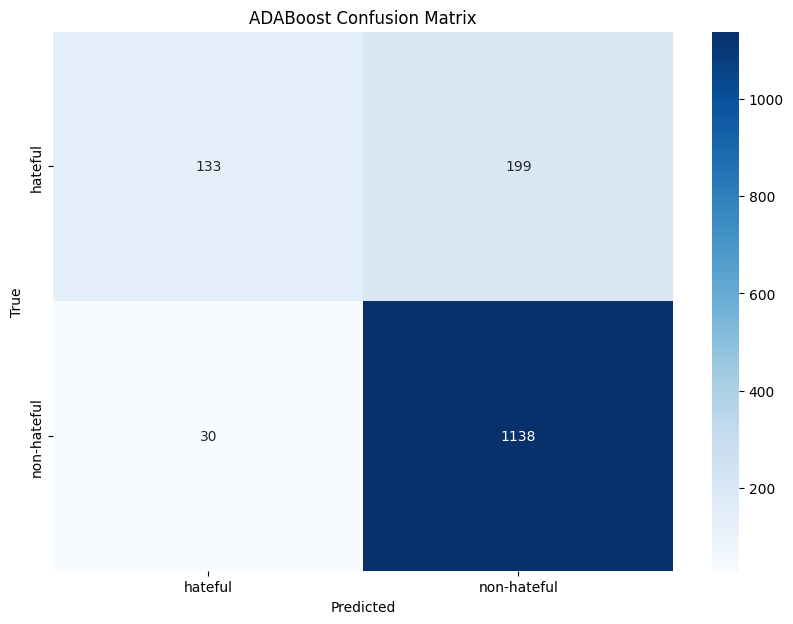

              precision    recall  f1-score   support

     hateful       0.82      0.40      0.54       332
 non-hateful       0.85      0.97      0.91      1168

    accuracy                           0.85      1500
   macro avg       0.83      0.69      0.72      1500
weighted avg       0.84      0.85      0.83      1500

Accuracy: 0.8473333333333334, Iteration: 1


In [14]:
from nltk.classify import SklearnClassifier, accuracy # Using SKLearn Classifier from nltk library enables us to use all the model algorithm that is available in SKlearn
from sklearn.ensemble import AdaBoostClassifier # Import the AdaBoost from SKlearn to be used

# Initialize iter and acc with 0
iter = 0
acc = 0

# Iterate until the accuracy exceeded 0.85 (max 10 iteration)
# For each iteration, the dataset will be shuffled
while acc < 0.80 and iter < 10:
    random.shuffle(dataset) # Shuffle the dataset

    # Train Test Split
    counter = int(len(dataset) * 0.7)
    train = dataset[:counter]
    test = dataset[counter:]

    classifier = SklearnClassifier(AdaBoostClassifier()).train(labeled_featuresets=train) # Train the SKlearn ADABoost classifier
    acc = accuracy(classifier, test)
    iter += 1

# Plot the accuracy matrix and classification report
test_features, test_labels, predictions = plot_confusion_matrix(test, classifier, 'ADABoost Confusion Matrix')
print_classification_report(test_labels, predictions, classifier.labels())

# Print the accuracy and append it to an array
accuracy_array.append(acc)
print(f"Accuracy: {acc}, Iteration: {iter}")

# Save the model to a joblib format
file = open('drive/MyDrive/NLP/adaboost.joblib', 'wb')
joblib.dump(classifier, file)
file.close()

# Decision Tree

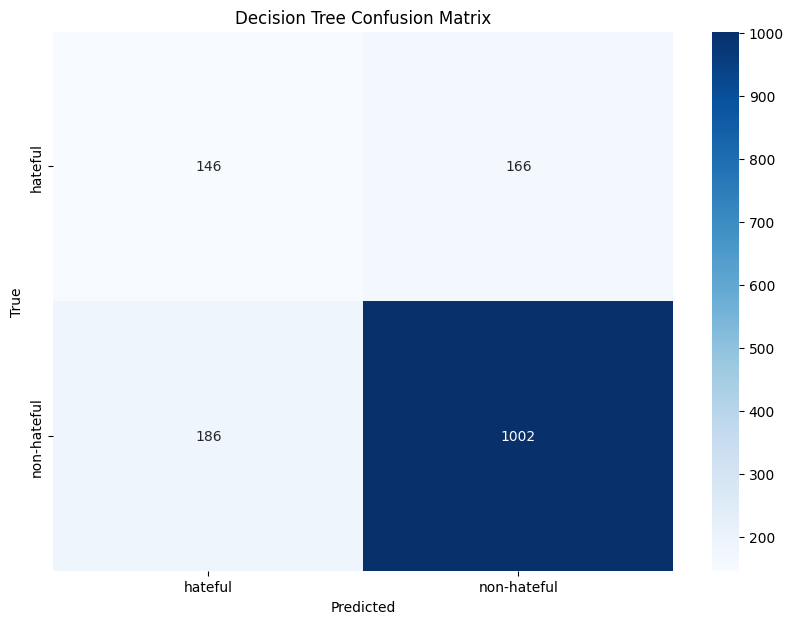

              precision    recall  f1-score   support

     hateful       0.44      0.47      0.45       312
 non-hateful       0.86      0.84      0.85      1188

    accuracy                           0.77      1500
   macro avg       0.65      0.66      0.65      1500
weighted avg       0.77      0.77      0.77      1500

Accuracy: 0.7653333333333333, Iteration: 10


In [15]:
from nltk.classify import SklearnClassifier, accuracy # Using SKLearn Classifier from nltk library enables us to use all the model algorithm that is available in SKlearn
from sklearn.tree import DecisionTreeClassifier # Import the DecisionTree from SKlearn to be used

# Initialize iter and acc with 0
iter = 0
acc = 0

# Iterate until the accuracy exceeded 0.85 (max 10 iteration)
# For each iteration, the dataset will be shuffled
while acc < 0.80 and iter < 10:
    random.shuffle(dataset)  # Shuffle the dataset

    # Train Test Split
    counter = int(len(dataset) * 0.7)
    train = dataset[:counter]
    test = dataset[counter:]

    classifier = SklearnClassifier(DecisionTreeClassifier()).train(labeled_featuresets=train) # Train the SKlearn Decision Tree classifier
    acc = accuracy(classifier, test)
    iter += 1

# Plot the accuracy matrix and classification report
test_features, test_labels, predictions = plot_confusion_matrix(test, classifier, 'Decision Tree Confusion Matrix')
print_classification_report(test_labels, predictions, classifier.labels())

# Print the accuracy and append it to an array
accuracy_array.append(acc)
print(f"Accuracy: {acc}, Iteration: {iter}")

# Save the model to a joblib format
file = open('drive/MyDrive/NLP/decisionTree.joblib', 'wb')
joblib.dump(classifier, file)
file.close()

# Summary

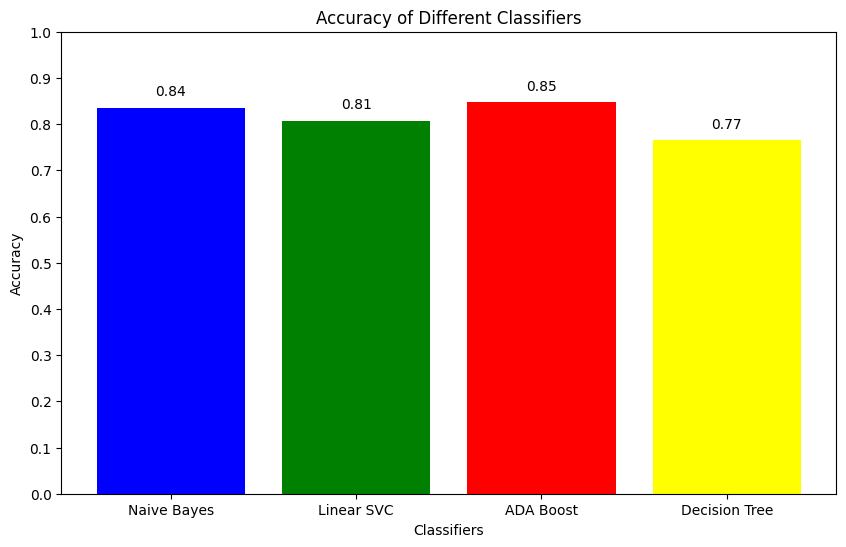

In [16]:
# Plot accuracy in bar
plt.figure(figsize=(10, 6))
plt.bar(accuracy_label, accuracy_array, color=['blue', 'green', 'red', 'yellow'])

# Add labels and title
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.ylim(0, 1)  # Set the y-axis limits to [0, 1] for better visualization
plt.yticks([i/10.0 for i in range(11)])  # Set y-ticks to show 0, 0.1, 0.2, ..., 1.0

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracy_array):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')

plt.show()

# Model Inference

In [17]:
import joblib
model = joblib.load('drive/MyDrive/NLP/adaboost.joblib') # Get the best performing model

# Test the model with user inputs, it will decide the user query to be
# hateful or non-hateful
for i in range(3):
  sentence_input = input('Enter a sentence: ')
  words = word_tokenize(sentence_input)
  result = model.classify(FreqDist(words))
  print(f"Sentence: {sentence_input}")
  print(f"Label: {result}")

Enter a sentence: This nigger bitch deserve to be served dead in jail ugly bitch ass fuck
Sentence: This nigger bitch deserve to be served dead in jail ugly bitch ass fuck
Label: hateful
Enter a sentence: I love waffles :D
Sentence: I love waffles :D
Label: non-hateful
Enter a sentence: Pak Wawan dosen idaman
Sentence: Pak Wawan dosen idaman
Label: non-hateful


In [18]:
import joblib
model = joblib.load('drive/MyDrive/NLP/naive.joblib')
print(f"10 Most informative feature: {model.show_most_informative_features(10)}") # For Naive

Most Informative Features
                  faggot = True           hatefu : non-ha =     86.5 : 1.0
                    scum = True           hatefu : non-ha =     23.6 : 1.0
                    dyke = True           hatefu : non-ha =     21.4 : 1.0
                    lost = True           hatefu : non-ha =     14.6 : 1.0
                  monkey = True           hatefu : non-ha =     12.4 : 1.0
                     com = True           non-ha : hatefu =     12.0 : 1.0
                    text = True           non-ha : hatefu =     12.0 : 1.0
                protocol = True           non-ha : hatefu =     11.0 : 1.0
                    shut = True           hatefu : non-ha =     10.1 : 1.0
                   worst = True           hatefu : non-ha =     10.1 : 1.0
10 Most informative feature: None
